In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract features from image
features = {}
directory = "/content/drive/MyDrive/Advanced Machinelearning/Imagecaption1/Images"

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8126 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

NameError: name 'features' is not defined

In [ ]:
# load features from pickle
with open("/content/drive/MyDrive/Advanced Machinelearning/Imagecaption1/features (1).pkl", 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/Advanced Machinelearning/Imagecaption1/captions.txt", 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)


8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)


In [ ]:
mapping['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:

all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:

vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

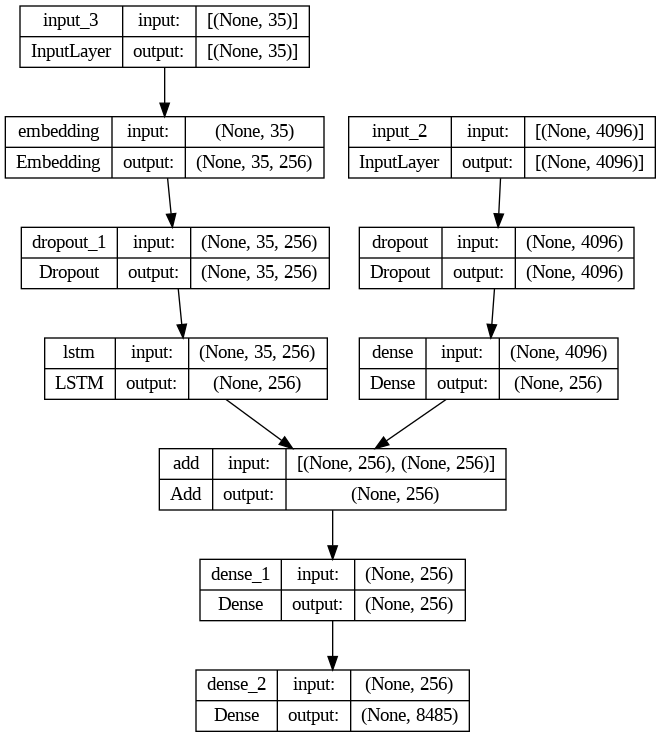

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
import pickle
import matplotlib.pyplot as plt

# ...

# Initialize an empty list to store the training history
all_history = []

In [ ]:
# train the model
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):

    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    all_history.append(history.history)

227/227 [==============================] - 59s 260ms/step - loss: 1.8184


In [ ]:
# Save the training history to a pickle file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(all_history, file)

# Plot the training history
losses = [epoch['loss'][0] for epoch in all_history]

plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


NameError: name 'pickle' is not defined

In [ ]:
all_history

[{'loss': [5.2134833335876465]},
 {'loss': [3.9922900199890137]},
 {'loss': [3.5682435035705566]},
 {'loss': [3.3086583614349365]},
 {'loss': [3.118941068649292]},
 {'loss': [2.974929094314575]},
 {'loss': [2.857313394546509]},
 {'loss': [2.7590699195861816]},
 {'loss': [2.67734956741333]},
 {'loss': [2.609949827194214]},
 {'loss': [2.552905797958374]},
 {'loss': [2.4976916313171387]},
 {'loss': [2.447025775909424]},
 {'loss': [2.410611152648926]},
 {'loss': [2.369300603866577]},
 {'loss': [2.3291518688201904]},
 {'loss': [2.290349245071411]},
 {'loss': [2.256526470184326]},
 {'loss': [2.223832845687866]},
 {'loss': [2.1996219158172607]},
 {'loss': [2.17000675201416]},
 {'loss': [2.141132354736328]},
 {'loss': [2.114264965057373]},
 {'loss': [2.092258930206299]},
 {'loss': [2.068112373352051]},
 {'loss': [2.0470399856567383]},
 {'loss': [2.024829149246216]},
 {'loss': [2.006463050842285]},
 {'loss': [1.9921773672103882]},
 {'loss': [1.9708645343780518]},
 {'loss': [1.956951379776001]},

In [ ]:
accuracies = [epoch['accuracy'][0] for epoch in all_history]

plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

KeyError: 'accuracy'

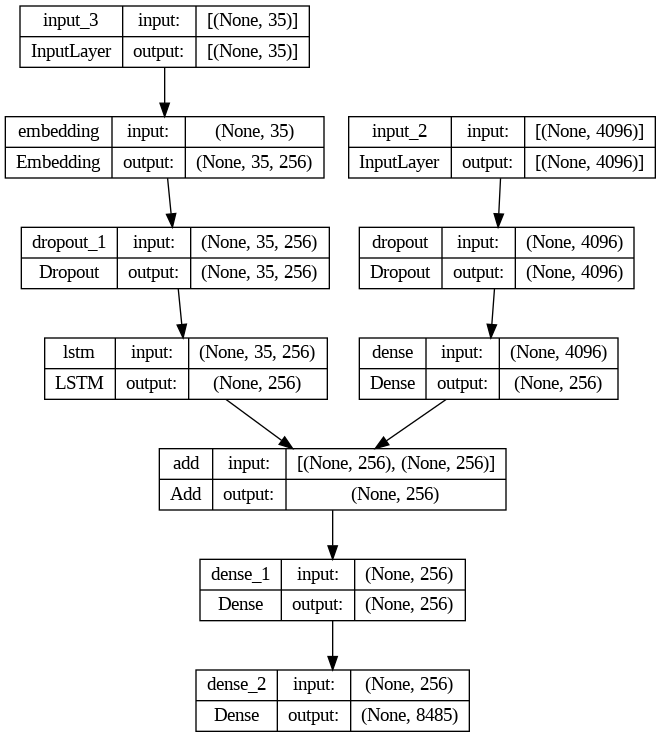

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)


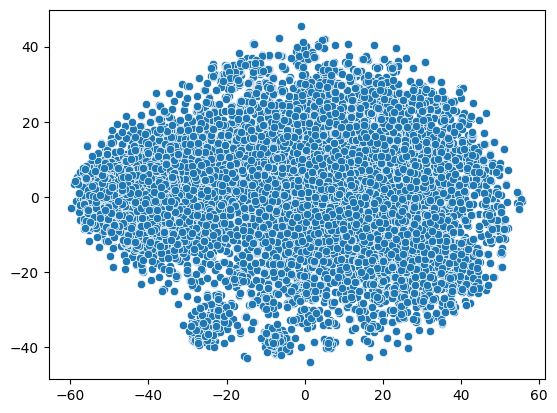

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Get word embeddings from the model
word_embeddings = model.layers[2].get_weights()[0]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(word_embeddings)

# Visualize
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])
plt.show()


In [ ]:
# save the model
model.save('best_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


NameError: name 'tqdm' is not defined

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/drive/MyDrive/Advanced Machinelearning/Imagecaption1/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("MaxLength : ", max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
import json
from tensorflow.keras import activations
from PIL import Image
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    # Load the image from file
    image = load_img(image_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    return image

def generate_caption(model, tokenizer, max_length, image):
    # Add start tag for the generation process
    in_text = 'startseq'

    # Iterate over the max length of the sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get the index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating the next word
        in_text += " " + word
        # Stop if we reach the end tag
        if word == 'endseq':
            break
    return in_text

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Load the pre-trained model
model_path = '/content/best_model.h5'
model = load_model(model_path)

from keras.preprocessing.text import tokenizer_from_json




# # Load the tokenizer
# tokenizer_path = '/content/tokenizer_path.json'
# with open(tokenizer_path, 'r', encoding='utf-8') as f:
#     tokenizer_json = json.load(f)
#     tokenizer = tokenizer_from_json(tokenizer_json)

# Set the maximum length of the caption
max_length = 35  # Adjust based on your model's configuration

# Path to the image you want to generate a caption for
image_path = '/content/Cataracteye.jpeg'
image = load_and_preprocess_image(image_path)

# Generate the caption
caption = generate_caption(model, tokenizer, max_length, image)
print('Generated Caption:', caption)

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model
import numpy as np

def load_tokenizer(tokenizer_path):
    with open(tokenizer_path, 'r', encoding='utf-8') as f:
        tokenizer_data = json.load(f)
        tokenizer = Tokenizer()
        tokenizer.word_index = tokenizer_data['word_index']
        tokenizer.index_word = tokenizer_data['index_word']
    return tokenizer

def extract_features(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def generate_caption(model, tokenizer, max_length, image_filename):
    photo = extract_features(image_filename)
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Load the trained model and tokenizer
model_path = '/content/best_model.h5'
tokenizer_path = '/content/tokenizer_path.json'
model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)

# Example usage
image_filename = '/content/WIN_20230423_23_26_43_Pro.jpg'
caption = generate_caption(model, tokenizer, max_length, image_filename)
print('Generated Caption:', caption)


In [ ]:
def save_tokenizer(tokenizer, tokenizer_path):
    tokenizer_data = {
        'word_index': tokenizer.word_index,
        'index_word': tokenizer.index_word
    }
    with open("tokenizer_path.json", 'w', encoding='utf-8') as f:
        json.dump(tokenizer_data, f)

# ... (other parts of your code)

# Save the tokenizer
save_tokenizer(tokenizer, tokenizer_path)
